# Chapter 4. Classifying Surnames with a Multilayer Perceptron

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [3]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping, now supporting n-grams"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>", ngram=2):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
            ngram (int): the size of n-grams (e.g., 1 for unigram, 2 for bigram)
        """
        if token_to_idx is None:
            token_to_idx = {}

        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token
        self.ngram = ngram

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)

    def add_token(self, token):
        """Update mapping dicts based on the token."""
        if token not in self._token_to_idx:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        else:
            index = self._token_to_idx[token]
        return index

    def add_ngrams_token(self, text):
        """Break text into n-grams and add them to the vocabulary."""
        tokens = [text[i:i+self.ngram] for i in range(len(text) - self.ngram + 1)]
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token or the UNK index if not present."""
        return self._token_to_idx.get(token, self.unk_index)

    def lookup_index(self, index):
        """Return the token associated with the index."""
        if index not in self._idx_to_token:
            raise KeyError(f"The index ({index}) is not in the Vocabulary")
        return self._idx_to_token[index]

    def __len__(self):
        return len(self._token_to_idx)

    def __str__(self):
        return f"<Vocabulary(size={len(self)})>"

### The Vectorizer

In [4]:
class SurnameVectorizer(object):
    """Vectorizer which coordinates the Vocabularies and puts them to use"""

    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps n-grams to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        ngram_tokens = [surname[i:i+vocab.ngram] for i in range(len(surname) - vocab.ngram + 1)]

        for token in ngram_tokens:
            one_hot[vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df, ngram=2):
        """Instantiate the vectorizer from the dataset dataframe."""
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            surname_vocab.add_ngrams_token(row.surname)  # Use n-grams
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

### The Dataset

In [5]:
class SurnameDataset(Dataset):
    """Dataset class that supports multi-gram characters"""

    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instantiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split == 'train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split == 'val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split == 'test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        class_counts = surname_df.nationality.value_counts().to_dict()
        sorted_counts = sorted(class_counts.items(), key=lambda x: self._vectorizer.nationality_vocab.lookup_token(x[0]))
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv, ngram=2):
        """Load dataset and make a new vectorizer from scratch."""
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split == 'train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df, ngram=ngram))

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """Primary entry point method for PyTorch datasets."""
        row = self._target_df.iloc[index]
        surname_vector = self._vectorizer.vectorize(row.surname)
        nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_vector, 'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    """A generator function that ensures each tensor is on the correct device."""
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {name: tensor.to(device) for name, tensor in data_dict.items()}
        yield out_data_dict

## The Model: SurnameClassifier

In [6]:
class SurnameClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.bn1 = nn.BatchNorm1d(hidden_dim) # for batch norm, need to be defined for each layer
        self.dpout = nn.Dropout(p=0.2) # for drop out, p = probability of an element to be zeroed. Default: 0.5


    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = self.fc1(x_in)                         # (batch, input_dim) -> (batch, hidden_dim)
        intermediate_vector = self.bn1(intermediate_vector)          # batch norm
        intermediate_vector = F.relu(intermediate_vector)            # activation function
        intermediate_vector = self.dpout(intermediate_vector)        # dropout

        prediction_vector = self.fc2(intermediate_vector)            # (batch, hidden_dim) -> (batch, output_dim)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)  # (batch, output_dim)

        return prediction_vector                                     # (batch, output_dim)

## Training Routine

### Helper functions

In [7]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [26]:
args = Namespace(
    # Data and path information
    surname_csv="/content/drive/MyDrive/take-home-project-no-1/take-home-project-no-1/mlp_surnames/data/surnames/surnames_with_splits.csv",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_mlp",
    # Model hyper parameters
    hidden_dim=200,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options
    cuda=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch4/surname_mlp/model.pth
Using CUDA: False


### Initializations

In [27]:
# create dataset and vectorizer
print("Creating fresh!")
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)

vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab),
                               hidden_dim=args.hidden_dim,
                               output_dim=len(vectorizer.nationality_vocab))


Creating fresh!


In [28]:
for idx, m in enumerate(classifier.named_modules()):
        print(idx, '->', m)

0 -> ('', SurnameClassifier(
  (fc1): Linear(in_features=954, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=18, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dpout): Dropout(p=0.2, inplace=False)
))
1 -> ('fc1', Linear(in_features=954, out_features=200, bias=True))
2 -> ('fc2', Linear(in_features=200, out_features=18, bias=True))
3 -> ('bn1', BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
4 -> ('dpout', Dropout(p=0.2, inplace=False))


In [29]:
for param in classifier.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([200, 954])
<class 'torch.nn.parameter.Parameter'> torch.Size([200])
<class 'torch.nn.parameter.Parameter'> torch.Size([18, 200])
<class 'torch.nn.parameter.Parameter'> torch.Size([18])
<class 'torch.nn.parameter.Parameter'> torch.Size([200])
<class 'torch.nn.parameter.Parameter'> torch.Size([200])


In [30]:
vectorizer.surname_vocab._token_to_idx

{'@': 0,
 'Ka': 1,
 'as': 2,
 'ss': 3,
 'si': 4,
 'is': 5,
 'Ma': 6,
 'aa': 7,
 'al': 8,
 'lo': 9,
 'ou': 10,
 'uf': 11,
 'Ra': 12,
 'ah': 13,
 'ha': 14,
 'Mi': 15,
 'if': 16,
 'fs': 17,
 'su': 18,
 'ud': 19,
 'Ba': 20,
 'ar': 21,
 'an': 22,
 'ns': 23,
 'so': 24,
 'ur': 25,
 'Ha': 26,
 'rb': 27,
 'Se': 28,
 'ei': 29,
 'Ga': 30,
 'ab': 31,
 'be': 32,
 'er': 33,
 'An': 34,
 'nt': 35,
 'ta': 36,
 'Sh': 37,
 'am': 38,
 'mo': 39,
 'un': 40,
 'az': 41,
 'zz': 42,
 'zi': 43,
 'na': 44,
 'Mo': 45,
 'or': 46,
 'rc': 47,
 'co': 48,
 'os': 49,
 'Bi': 50,
 'it': 51,
 'At': 52,
 'ti': 53,
 'iy': 54,
 'ye': 55,
 'eh': 56,
 'Ch': 57,
 'Am': 58,
 'ma': 59,
 'ri': 60,
 'Sa': 61,
 'bb': 62,
 'ba': 63,
 'ag': 64,
 'As': 65,
 'sk': 66,
 'ke': 67,
 'sw': 68,
 'wa': 69,
 'ad': 70,
 'lh': 71,
 'ho': 72,
 'ub': 73,
 'di': 74,
 'id': 75,
 'ai': 76,
 'mm': 77,
 'li': 78,
 'ib': 79,
 'ih': 80,
 'Es': 81,
 'sa': 82,
 'rr': 83,
 'ra': 84,
 'af': 85,
 'da': 86,
 'ay': 87,
 'eg': 88,
 'gh': 89,
 'Na': 90,
 'aj': 91,

In [31]:
vectorizer.nationality_vocab._token_to_idx

{'Arabic': 0,
 'Chinese': 1,
 'Czech': 2,
 'Dutch': 3,
 'English': 4,
 'French': 5,
 'German': 6,
 'Greek': 7,
 'Irish': 8,
 'Italian': 9,
 'Japanese': 10,
 'Korean': 11,
 'Polish': 12,
 'Portuguese': 13,
 'Russian': 14,
 'Scottish': 15,
 'Spanish': 16,
 'Vietnamese': 17}

### Training loop

In [32]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)


loss_func = nn.CrossEntropyLoss(dataset.class_weights)  # add class_weight for an unbalanced dataset
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
#optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=0.001) # weight_decay for L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10) # update learning rate

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])         # (batch, input_dim) -> (batch, output_dim)

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])  # (batch, output_dim), (batch) -> scalar value
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

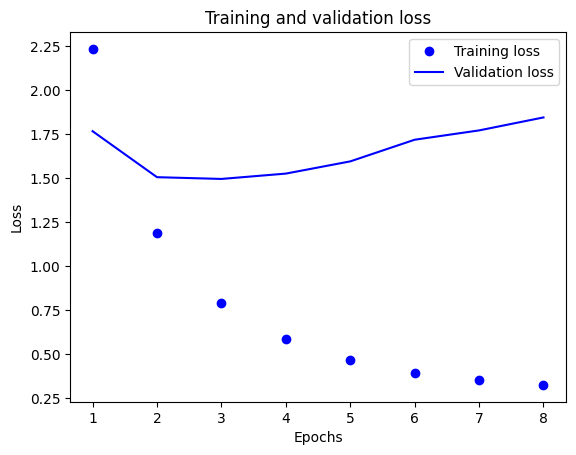

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

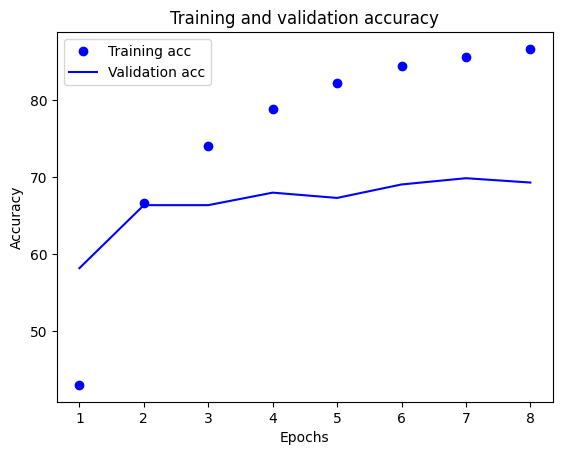

In [34]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename'], weights_only=False)) # load the best model

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_nationality_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])

    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend(y_pred.max(dim=1)[1].numpy())
    y_nationality_list.extend(batch_dict['y_nationality'].numpy())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [36]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.3206132626533507;
Test Accuracy: 67.0625


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_nationality_list, y_pred_list).T)

[[232   0   2   0   1   0   1   1   0   2   3   0   0   0   5   0   0   0]
 [  0  18   0   0   8   0   1   0   0   0   2   1   0   0   2   1   0   4]
 [  0   0  23   1  11   0   5   1   0   1   1   0   0   0   7   0   2   0]
 [  0   0   2  20  24   0   8   0   0   3   0   0   1   0   4   0   1   0]
 [  0   1   4   3 193   1   7   0   5   2   0   0   0   1   1   4   0   0]
 [  0   1   1   1  26  18   1   0   1   1   0   0   0   0   3   0   1   0]
 [  0   1   9   4  20   2  45   0   0   1   0   0   0   0   7   1   3   1]
 [  0   0   1   0   5   1   0  19   0   2   0   0   1   1   2   0   1   0]
 [  0   0   0   0  27   1   1   0  13   2   0   1   1   0   0   0   1   0]
 [  0   0   3   0  17   3   2   0   0  59   2   0   0   1   8   1   8   0]
 [  0   0   2   0   8   0   0   1   2   2  98   0   0   0   6   0   1   1]
 [  1   8   0   0   9   1   2   0   0   1   2  10   0   0   2   0   0   1]
 [  0   0   4   1   2   0   1   0   0   0   0   0  13   0  10   0   1   0]
 [  0   1   2   1  13   5

In [38]:
nationality_classes = []
for i in range(len(dataset._vectorizer.nationality_vocab)):
    nationality_classes.append(dataset._vectorizer.nationality_vocab.lookup_index(i))
print(nationality_classes)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [39]:
import pandas as pd
cm = confusion_matrix(y_nationality_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=nationality_classes, columns=nationality_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True        Arabic  Chinese  Czech  Dutch  English  French  German  Greek  \
Predicted                                                                   
Arabic         232        0      2      0        1       0       1      1   
Chinese          0       18      0      0        8       0       1      0   
Czech            0        0     23      1       11       0       5      1   
Dutch            0        0      2     20       24       0       8      0   
English          0        1      4      3      193       1       7      0   
French           0        1      1      1       26      18       1      0   
German           0        1      9      4       20       2      45      0   
Greek            0        0      1      0        5       1       0     19   
Irish            0        0      0      0       27       1       1      0   
Italian          0        0      3      0       17       3       2      0   
Japanese         0        0      2      0        8       0       0      1   

In [40]:
print(classification_report(y_nationality_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       233
           1       0.49      0.55      0.51        33
           2       0.44      0.38      0.41        61
           3       0.32      0.57      0.41        35
           4       0.87      0.46      0.60       422
           5       0.33      0.51      0.40        35
           6       0.48      0.54      0.51        83
           7       0.58      0.79      0.67        24
           8       0.28      0.48      0.35        27
           9       0.57      0.66      0.61        89
          10       0.81      0.88      0.84       112
          11       0.27      0.77      0.40        13
          12       0.41      0.72      0.52        18
          13       0.12      0.44      0.19         9
          14       0.92      0.82      0.87       345
          15       0.10      0.42      0.17        12
          16       0.34      0.44      0.38        39
          17       0.18    